**To do list**:


1.   example balanced dataset, and make it balanced dataset (hit:lab4 , data augmentation)
2.   Install STN for better presentation of the dataset
3.   How centerface work
4. how to predict on vedio
5. how to create a timeline & statistcks of emotions



In [1]:
# import library
import torch
from tqdm import tqdm
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
import splitfolders
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
def train(net,train_data,val_data, batch_size, lr, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    iters, train_losses, val_losses,train_accs, val_accs = [], [], [], [], []
    n=0
    '''
    Training Loop
    '''
    print("===================================Start Training===================================")
    for e in range(num_epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)

        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss/len(train_data)
        train_losses.append(float(train_loss))
        train_acc = train_correct.double() / len(train_data)
        train_accs.append(train_acc.tolist())
        validation_loss =  validation_loss / len(val_data)
        val_losses.append(float(val_loss))
        val_acc = val_correct.double() / len(val_data)
        val_accs.append(val_acc.tolist())
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))
        iters.append(n)
        n=n+1
        if val_acc-train_acc>0.01:
          print("potential overfitting")
          checkpoint={'state_dict':model.state_dict(),'optimizer':optimizer.state_dict()}
          save_checkpoint(checkpoint)
    #torch.save(net.state_dict(),'deep_emotion-{}-{}-{}.pt'.format(num_epochs,batch_size,lr))
    print("===================================Training Finished===================================")
        # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_accs, label="Train")
    plt.plot(iters, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # convolution layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1, 1), stride=1, padding=0)
        # block1
        # convolution layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        # PReLU activation function
        self.prelu1 = nn.PReLU()
        # convolution layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5), stride=1, padding=2)
        self.prelu2 = nn.PReLU()
        # max pooling layer
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        # block2
        # convolution layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        self.prelu3 = nn.PReLU()
        # convolution layer
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5), stride=1, padding=2)
        self.prelu4 = nn.PReLU()
        # max pooling layer
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        # Full connection layer
        self.fc1 = nn.Linear(in_features=64*12*12, out_features=2048)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=2048, out_features=1024)
        self.dropout2 = nn.Dropout(p=0.5)
        # softmax function
        self.fc3 = nn.Linear(in_features=1024, out_features=7)
        
    def forward(self, x):
        # input layer
        x = self.conv1(x)
        # block1
        x = self.conv2(x)
        x = self.prelu1(x)
        x = self.conv3(x)
        x = self.prelu2(x)
        x = self.maxpool1(x)
        # block2
        x = self.conv4(x)
        x = self.prelu3(x)
        x = self.conv5(x)
        x = self.prelu4(x)
        x = self.maxpool2(x)
        # Full connection layer
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [ ]:
def save_checkpoint(state, filename="checkpoint.pth.tar"):
  print("======> saveing checkpoint")
  torch.save(state,filename)

In [ ]:
def load_checkpoint(checkpoint):
  print("======> loading checkpoint")
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimi'])

**CK+ dataset**

In [ ]:
# splite data

# The ratio of training, validation, test data are 0.7,0.2,0.1
tra_data_ratio=0.7
val_data_ratio=0.2
test_data_ratio=1-tra_data_ratio-val_data_ratio
input_folder=r"F:\MIE 1517 project\CK dataset\CK+48"
output_folder=r"F:\MIE 1517 project\CK dataset\Splite_data"
splitfolders.ratio(input_folder,output=output_folder,seed=57, ratio=(tra_data_ratio,val_data_ratio,test_data_ratio))

Copying files: 981 files [00:02, 481.75 files/s]


In [ ]:
# Data loder

# define data directories

data_dir = r"F:\MIE 1517 project\CK dataset\Splite_data"
train_dir = os.path.join(data_dir, 'train')
print(train_dir)
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# classes are folders in each directory with these names
classes = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprised', 'contempt']


# load and transfrom data 
data_transform = transforms.Compose([transforms.Resize(48), 
                                     transforms.Grayscale(),
                                     transforms.CenterCrop(48),
                                     transforms.ToTensor()])


train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num testing images: ', len(test_data))

F:\MIE 1517 project\CK dataset\Splite_data\train
Num training images:  682
Num validation images:  193
Num testing images:  106


CUDA is available!  Training on GPU ...
===================================Start Training===================================
Epoch: 1 	Training Loss: 0.03127382 	Validation Loss 0.03972627 	Training Acuuarcy 19.062% 	Validation Acuuarcy 25.389%
potential overfitting
======> saveing checkpoint
Epoch: 2 	Training Loss: 0.03027279 	Validation Loss 0.03756653 	Training Acuuarcy 25.513% 	Validation Acuuarcy 25.389%
Epoch: 3 	Training Loss: 0.02971636 	Validation Loss 0.03579741 	Training Acuuarcy 24.633% 	Validation Acuuarcy 25.389%
Epoch: 4 	Training Loss: 0.02957049 	Validation Loss 0.03646127 	Training Acuuarcy 25.513% 	Validation Acuuarcy 25.389%
Epoch: 5 	Training Loss: 0.02941478 	Validation Loss 0.03711187 	Training Acuuarcy 25.513% 	Validation Acuuarcy 25.389%
Epoch: 6 	Training Loss: 0.02939909 	Validation Loss 0.03681621 	Training Acuuarcy 25.953% 	Validation Acuuarcy 25.389%
Epoch: 7 	Training Loss: 0.02927718 	Validation Loss 0.03827894 	Training Acuuarcy 25.513% 	Validation Acu

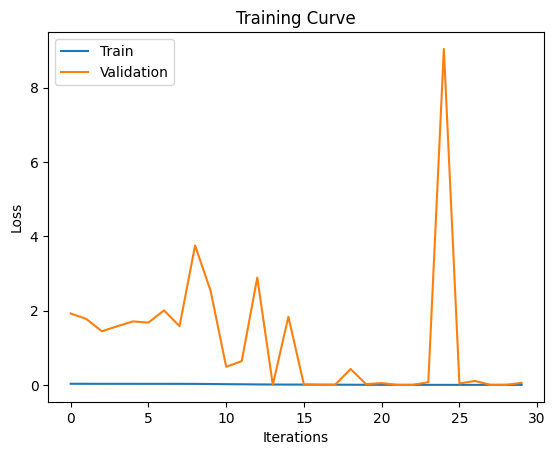

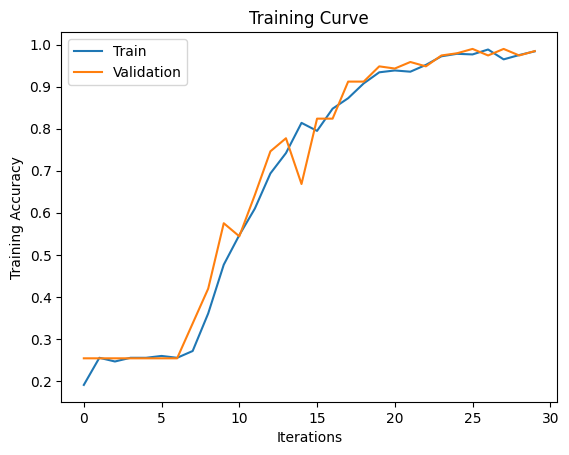

In [ ]:
model = CNN()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(model, train_data,val_data, batch_size=64, lr=0.01, num_epochs=30)

CUDA is available!  Training on GPU ...
===================================Start Training===================================
Epoch: 1 	Training Loss: 0.03110292 	Validation Loss 0.03765163 	Training Acuuarcy 24.487% 	Validation Acuuarcy 25.389%
Epoch: 2 	Training Loss: 0.02994589 	Validation Loss 0.03813631 	Training Acuuarcy 24.633% 	Validation Acuuarcy 25.389%
Epoch: 3 	Training Loss: 0.02976028 	Validation Loss 0.03682354 	Training Acuuarcy 23.754% 	Validation Acuuarcy 25.389%
potential overfitting
Epoch: 4 	Training Loss: 0.02996690 	Validation Loss 0.03716858 	Training Acuuarcy 22.874% 	Validation Acuuarcy 25.389%
potential overfitting
Epoch: 5 	Training Loss: 0.02967715 	Validation Loss 0.03519223 	Training Acuuarcy 25.806% 	Validation Acuuarcy 25.389%
Epoch: 6 	Training Loss: 0.02956514 	Validation Loss 0.03576790 	Training Acuuarcy 25.513% 	Validation Acuuarcy 25.389%
Epoch: 7 	Training Loss: 0.02944863 	Validation Loss 0.04059534 	Training Acuuarcy 25.513% 	Validation Acuuarcy

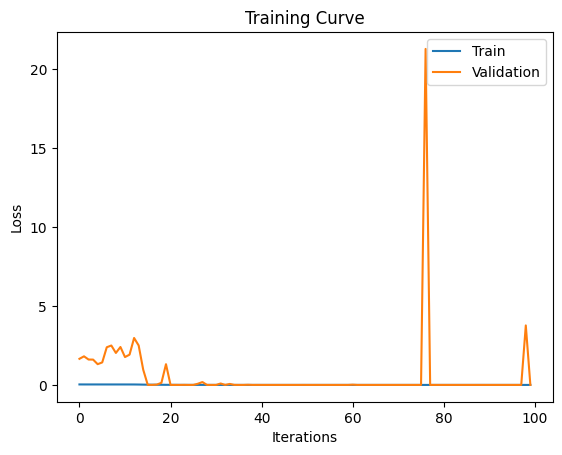

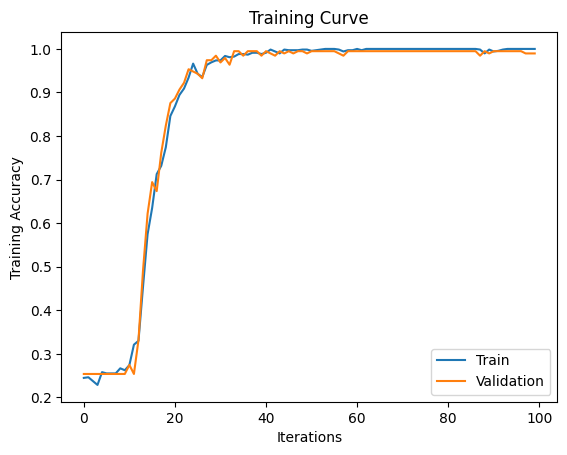

In [ ]:
model = CNN()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(model, train_data,val_data, batch_size=64, lr=0.01, num_epochs=100)

**Affectnet Data**

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # convolution layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(1, 1), stride=1, padding=0)
        # block1
        # convolution layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        # PReLU activation function
        self.prelu1 = nn.PReLU()
        # convolution layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5), stride=1, padding=2)
        self.prelu2 = nn.PReLU()
        # max pooling layer
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        # block2
        # convolution layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        self.prelu3 = nn.PReLU()
        # convolution layer
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5), stride=1, padding=2)
        self.prelu4 = nn.PReLU()
        # max pooling layer
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        # Full connection layer
        self.fc1 = nn.Linear(in_features=64*12*12, out_features=2048)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=2048, out_features=1024)
        self.dropout2 = nn.Dropout(p=0.5)
        # softmax function
        self.fc3 = nn.Linear(in_features=1024, out_features=8)
        
    def forward(self, x):
        # input layer
        x = self.conv1(x)
        # block1
        x = self.conv2(x)
        x = self.prelu1(x)
        x = self.conv3(x)
        x = self.prelu2(x)
        x = self.maxpool1(x)
        # block2
        x = self.conv4(x)
        x = self.prelu3(x)
        x = self.conv5(x)
        x = self.prelu4(x)
        x = self.maxpool2(x)
        # Full connection layer
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [ ]:
# splite data

# The ratio of training, validation, test data are 0.7,0.2,0.1
tra_data_ratio=0.7
val_data_ratio=0.2
test_data_ratio=1-tra_data_ratio-val_data_ratio
input_folder=r"F:\MIE 1517 project\Affectent dataset\affectent"
output_folder=r"F:\MIE 1517 project\Affectent dataset\split_data"
splitfolders.ratio(input_folder,output=output_folder,seed=57, ratio=(tra_data_ratio,val_data_ratio,test_data_ratio))

Copying files: 29042 files [01:24, 344.56 files/s]


In [ ]:
# Data loder

# define data directories

data_dir = r"F:\MIE 1517 project\Affectent dataset\split_data"
train_dir = os.path.join(data_dir, 'train')
print(train_dir)
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# classes are folders in each directory with these names
classes = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprised', 'contempt','neutral']


# load and transfrom data 
data_transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num testing images: ', len(test_data))


F:\MIE 1517 project\Affectent dataset\split_data\train
Num training images:  20325
Num validation images:  5805
Num testing images:  2912


CUDA is available!  Training on GPU ...


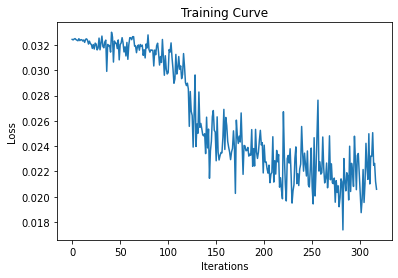

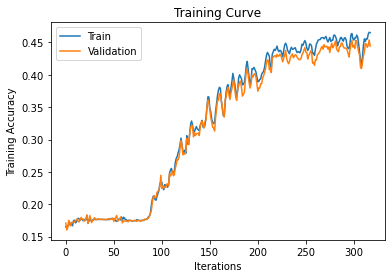

Final Training Accuracy: 0.4650430504305043
Final Validation Accuracy:  0.44427217915590006


In [ ]:
#proper model
model = CNN()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model, train_data, batch_size=64, lr=0.01, num_epochs=1)

CUDA is available!  Training on GPU ...


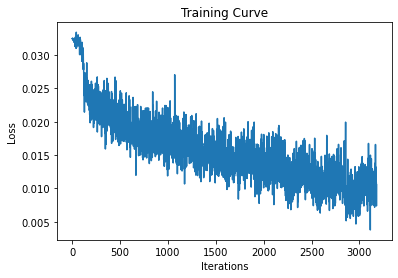

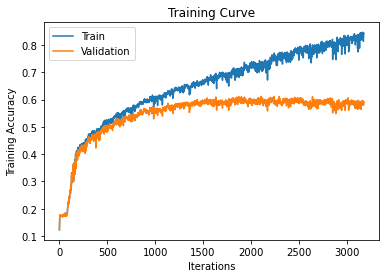

Final Training Accuracy: 0.8424108241082411
Final Validation Accuracy:  0.5822566752799311


In [ ]:
#proper model
model = CNN()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model, train_data, batch_size=64, lr=0.01, num_epochs=10)

CUDA is available!  Training on GPU ...
===================================Start Training===================================
Epoch: 1 	Training Loss: 0.02627403 	Validation Loss 0.02105231 	Training Acuuarcy 32.699% 	Validation Acuuarcy 45.840%
potential overfitting
======> saveing checkpoint
Epoch: 2 	Training Loss: 0.01991699 	Validation Loss 0.01916598 	Training Acuuarcy 50.819% 	Validation Acuuarcy 52.231%
potential overfitting
======> saveing checkpoint
Epoch: 3 	Training Loss: 0.01810064 	Validation Loss 0.01764933 	Training Acuuarcy 56.320% 	Validation Acuuarcy 57.812%
potential overfitting
======> saveing checkpoint
Epoch: 4 	Training Loss: 0.01662596 	Validation Loss 0.01683732 	Training Acuuarcy 60.128% 	Validation Acuuarcy 59.276%
Epoch: 5 	Training Loss: 0.01547756 	Validation Loss 0.01638460 	Training Acuuarcy 62.908% 	Validation Acuuarcy 60.775%
Epoch: 6 	Training Loss: 0.01443163 	Validation Loss 0.01682952 	Training Acuuarcy 65.702% 	Validation Acuuarcy 60.930%
Epoch: 7

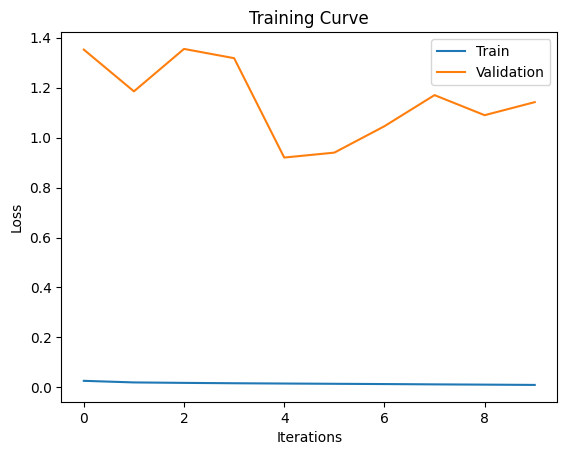

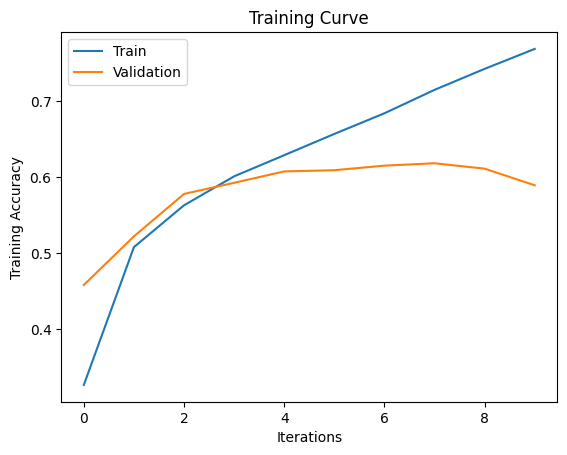

In [ ]:
#proper model
model = CNN()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model, train_data,val_data, batch_size=64, lr=0.01, num_epochs=10)

CUDA is available!  Training on GPU ...
===================================Start Training===================================
Epoch: 1 	Training Loss: 0.01547546 	Validation Loss 0.01249809 	Training Acuuarcy 20.394% 	Validation Acuuarcy 36.124%
potential overfitting
Epoch: 2 	Training Loss: 0.01110930 	Validation Loss 0.01047324 	Training Acuuarcy 43.380% 	Validation Acuuarcy 47.941%
potential overfitting
Epoch: 3 	Training Loss: 0.00994653 	Validation Loss 0.00972218 	Training Acuuarcy 50.932% 	Validation Acuuarcy 51.214%
Epoch: 4 	Training Loss: 0.00920987 	Validation Loss 0.00916917 	Training Acuuarcy 55.149% 	Validation Acuuarcy 55.487%
Epoch: 5 	Training Loss: 0.00868029 	Validation Loss 0.00880882 	Training Acuuarcy 57.924% 	Validation Acuuarcy 57.984%
Epoch: 6 	Training Loss: 0.00821731 	Validation Loss 0.00869369 	Training Acuuarcy 60.595% 	Validation Acuuarcy 58.312%
Epoch: 7 	Training Loss: 0.00771491 	Validation Loss 0.00842751 	Training Acuuarcy 63.109% 	Validation Acuuarcy

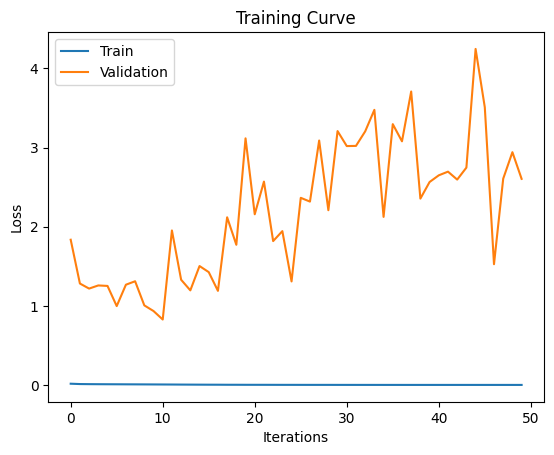

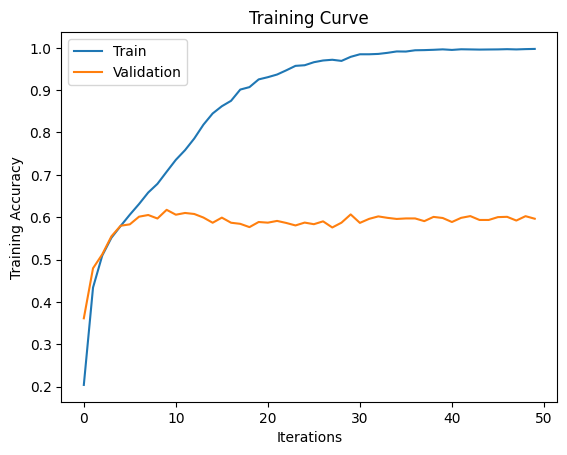

In [ ]:
#rgb 
model = CNN()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model, train_data,val_data, batch_size=128, lr=0.01, num_epochs=50)

CUDA is available!  Training on GPU ...
===================================Start Training===================================
Epoch: 1 	Training Loss: 0.03219038 	Validation Loss 0.03204378 	Training Acuuarcy 17.132% 	Validation Acuuarcy 17.657%
Epoch: 2 	Training Loss: 0.03177441 	Validation Loss 0.03107819 	Training Acuuarcy 18.130% 	Validation Acuuarcy 22.239%
potential overfitting
Epoch: 3 	Training Loss: 0.02738838 	Validation Loss 0.02370953 	Training Acuuarcy 29.515% 	Validation Acuuarcy 35.538%
potential overfitting
Epoch: 4 	Training Loss: 0.02280247 	Validation Loss 0.02189882 	Training Acuuarcy 41.117% 	Validation Acuuarcy 44.203%
potential overfitting
Epoch: 5 	Training Loss: 0.02159638 	Validation Loss 0.02131114 	Training Acuuarcy 45.506% 	Validation Acuuarcy 46.460%
Epoch: 6 	Training Loss: 0.02094287 	Validation Loss 0.02058826 	Training Acuuarcy 47.857% 	Validation Acuuarcy 48.165%
Epoch: 7 	Training Loss: 0.02036402 	Validation Loss 0.02001987 	Training Acuuarcy 49.402

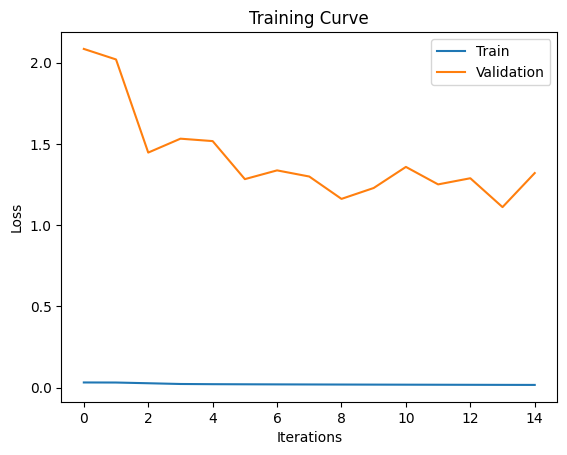

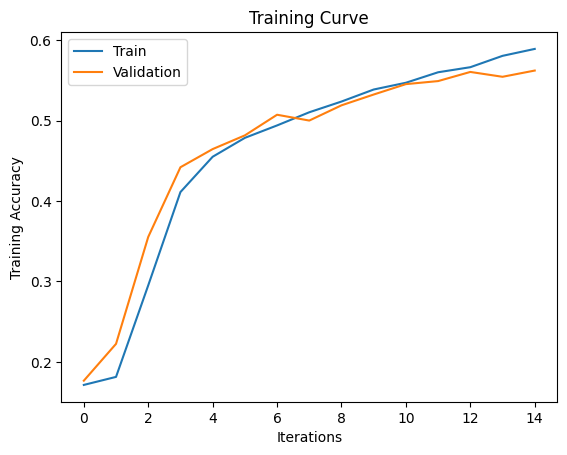

In [ ]:
#rgb 
model = CNN()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model, train_data,val_data, batch_size=64, lr=0.001, num_epochs=15)

CUDA is available!  Training on GPU ...
===================================Start Training===================================
Epoch: 1 	Training Loss: 0.02691470 	Validation Loss 0.02153315 	Training Acuuarcy 30.480% 	Validation Acuuarcy 46.391%
potential overfitting
======> saveing checkpoint
Epoch: 2 	Training Loss: 0.01998847 	Validation Loss 0.01875271 	Training Acuuarcy 50.214% 	Validation Acuuarcy 53.454%
potential overfitting
======> saveing checkpoint
Epoch: 3 	Training Loss: 0.01817816 	Validation Loss 0.01821241 	Training Acuuarcy 56.133% 	Validation Acuuarcy 55.366%
Epoch: 4 	Training Loss: 0.01678812 	Validation Loss 0.01680188 	Training Acuuarcy 59.208% 	Validation Acuuarcy 59.587%
Epoch: 5 	Training Loss: 0.01540495 	Validation Loss 0.01663771 	Training Acuuarcy 63.124% 	Validation Acuuarcy 60.189%
Epoch: 6 	Training Loss: 0.01440549 	Validation Loss 0.01650748 	Training Acuuarcy 65.845% 	Validation Acuuarcy 61.292%
Epoch: 7 	Training Loss: 0.01325419 	Validation Loss 0.01

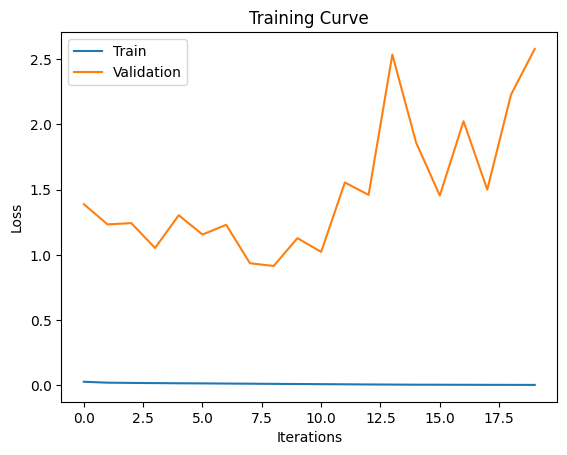

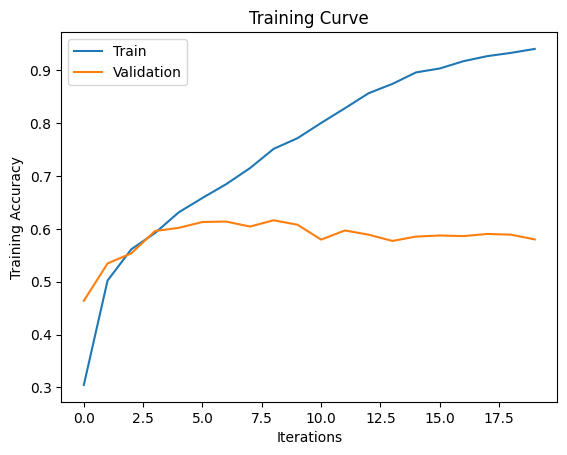

In [ ]:
#rgb 
model = CNN()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model, train_data,val_data, batch_size=64, lr=0.01, num_epochs=20)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # convolution layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1, 1), stride=1, padding=0)
        # block1
        # convolution layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        # PReLU activation function
        self.prelu1 = nn.PReLU()
        # convolution layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5), stride=1, padding=2)
        self.prelu2 = nn.PReLU()
        # max pooling layer
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        # block2
        # convolution layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        self.prelu3 = nn.PReLU()
        # convolution layer
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5), stride=1, padding=2)
        self.prelu4 = nn.PReLU()
        # max pooling layer
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        # Full connection layer
        self.fc1 = nn.Linear(in_features=64*12*12, out_features=2048)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=2048, out_features=1024)
        self.dropout2 = nn.Dropout(p=0.5)
        # softmax function
        self.fc3 = nn.Linear(in_features=1024, out_features=8)
        
    def forward(self, x):
        # input layer
        x = self.conv1(x)
        # block1
        x = self.conv2(x)
        x = self.prelu1(x)
        x = self.conv3(x)
        x = self.prelu2(x)
        x = self.maxpool1(x)
        # block2
        x = self.conv4(x)
        x = self.prelu3(x)
        x = self.conv5(x)
        x = self.prelu4(x)
        x = self.maxpool2(x)
        # Full connection layer
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [ ]:
# grascale
# Data loder

# define data directories

data_dir = r"F:\MIE 1517 project\Affectent dataset\split_data"
train_dir = os.path.join(data_dir, 'train')
print(train_dir)
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# classes are folders in each directory with these names
classes = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprised', 'contempt','neutral']


# load and transfrom data 
data_transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num testing images: ', len(test_data))


F:\MIE 1517 project\Affectent dataset\split_data\train
Num training images:  20325
Num validation images:  5805
Num testing images:  2912


CUDA is available!  Training on GPU ...
===================================Start Training===================================
Epoch: 1 	Training Loss: 0.02700789 	Validation Loss 0.02131406 	Training Acuuarcy 30.480% 	Validation Acuuarcy 44.755%
potential overfitting
======> saveing checkpoint
Epoch: 2 	Training Loss: 0.02023986 	Validation Loss 0.01913051 	Training Acuuarcy 49.565% 	Validation Acuuarcy 53.144%
potential overfitting
======> saveing checkpoint
Epoch: 3 	Training Loss: 0.01825167 	Validation Loss 0.01784859 	Training Acuuarcy 55.616% 	Validation Acuuarcy 57.743%
potential overfitting
======> saveing checkpoint
Epoch: 4 	Training Loss: 0.01685640 	Validation Loss 0.01699631 	Training Acuuarcy 59.734% 	Validation Acuuarcy 58.863%
Epoch: 5 	Training Loss: 0.01571423 	Validation Loss 0.01679966 	Training Acuuarcy 62.554% 	Validation Acuuarcy 59.466%
Epoch: 6 	Training Loss: 0.01464809 	Validation Loss 0.01722716 	Training Acuuarcy 65.122% 	Validation Acuuarcy 58.966%
Epoch: 7

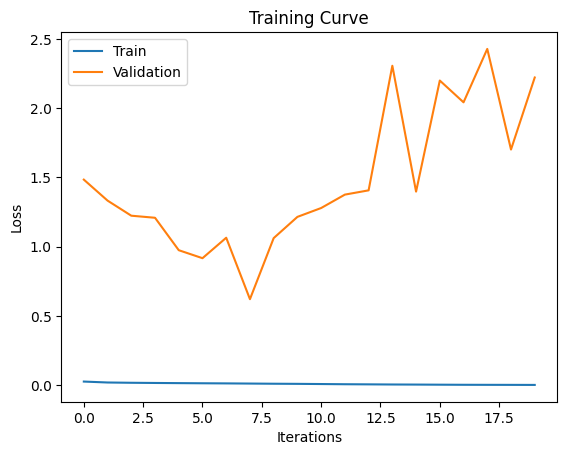

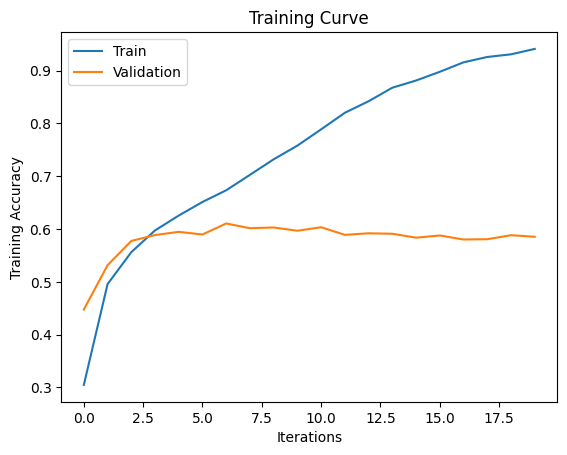

In [ ]:
#rgb 
model = CNN()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model, train_data,val_data, batch_size=64, lr=0.01, num_epochs=20)

In [ ]:
import numpy as np
import cv2
import pickle

import time



face_cascade = cv2.CascadeClassifier('/Users/suzhewu/Desktop/project/cascades/data/haarcascade_frontalface_alt2.xml')

photo_count = 0
labels = {}
flage = True


while(flage):
    cap = cv2.VideoCapture(0)
    ret,frame = cap.read()
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,scaleFactor = 1.5, minNeighbors=5)
    for (x,y,w,h) in faces:
        
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.imshow('frame',frame)
    
    if cv2.waitKey(1)& 0xFF == ord('q'):
        break


        
        
        
    cv2.imshow('frame',frame)
    if cv2.waitKey(20) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()  

error: ignored

# Centerface

## Model

In [5]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import os
import time
import cv2
import math
from collections import OrderedDict
# from google.colab.patches import cv2_imshow

In [6]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
        )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self,width_mult=1.0,round_nearest=8,):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1], # 0
            [6, 24, 2, 2], # 1
            [6, 32, 3, 2], # 2
            [6, 64, 4, 2], # 3
            [6, 96, 3, 1], # 4
            [6, 160, 3, 2],# 5
            [6, 320, 1, 1],# 6
        ]
        self.feat_id = [1,2,4,6]
        self.feat_channel = []

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        features = [ConvBNReLU(3, input_channel, stride=2)]

        # building inverted residual blocks
        for id,(t, c, n, s) in enumerate(inverted_residual_setting):
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
            if id in self.feat_id  :
                self.__setattr__("feature_%d"%id,nn.Sequential(*features))
                self.feat_channel.append(output_channel)
                features = []

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        y = []
        for id in self.feat_id:
            x = self.__getattr__("feature_%d"%id)(x)
            y.append(x)
        return y

In [7]:
class IDAUp(nn.Module):
    def __init__(self, out_dim, channel):
        super(IDAUp, self).__init__()
        self.out_dim = out_dim
        self.up = nn.Sequential(
                    nn.ConvTranspose2d(
                        out_dim, out_dim, kernel_size=2, stride=2, padding=0,
                        output_padding=0, groups=out_dim, bias=False),
                    nn.BatchNorm2d(out_dim,eps=0.001,momentum=0.1),
                    nn.ReLU())
        self.conv =  nn.Sequential(
                    nn.Conv2d(channel, out_dim,
                              kernel_size=1, stride=1, bias=False),
                    nn.BatchNorm2d(out_dim,eps=0.001,momentum=0.1),
                    nn.ReLU(inplace=True))
        # self.smooth = nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, layers):
        layers = list(layers)
        x = self.up(layers[0])
        y = self.conv(layers[1])
        # out = self.smooth(x + y)
        out = x + y
        return out

class MobileNetUp(nn.Module):
    def __init__(self, channels, out_dim = 24):
        super(MobileNetUp, self).__init__()
        channels =  channels[::-1]
        self.conv =  nn.Sequential(
                    nn.Conv2d(channels[0], out_dim,
                              kernel_size=1, stride=1, bias=False),
                    nn.BatchNorm2d(out_dim,eps=0.001,momentum=0.1),
                    nn.ReLU(inplace=True))
        self.conv_last =  nn.Sequential(
                    nn.Conv2d(out_dim,out_dim,
                              kernel_size=3, stride=1, padding=1 ,bias=False),
                    nn.BatchNorm2d(out_dim,eps=1e-5,momentum=0.01),
                    nn.ReLU(inplace=True))

        for i,channel in enumerate(channels[1:]):
            setattr(self,'up_%d'%(i),IDAUp(out_dim,channel))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m,nn.ConvTranspose2d):
                w = m.weight.data
                f = math.ceil(w.size(2) / 2)
                c = (2 * f - 1 - f % 2) / (2. * f)
                for i in range(w.size(2)):
                    for j in range(w.size(3)):
                        w[0, 0, i, j] = \
                            (1 - math.fabs(i / f - c)) * (1 - math.fabs(j / f - c))
                for c in range(1, w.size(0)):
                    w[c, 0, :, :] = w[0, 0, :, :]

    def forward(self, layers):
        layers = list(layers)
        assert len(layers) > 1
        x = self.conv(layers[-1])

        for i in range(0,len(layers)-1):
            up = getattr(self, 'up_{}'.format(i))
            x = up([x,layers[len(layers)-2-i]])
        x = self.conv_last(x)
        return x
class MobileNetSeg(nn.Module):
    def __init__(self, base_name, heads, head_conv=24, pretrained = True):
        super(MobileNetSeg, self).__init__()
        self.heads = heads
        self.base = globals()[base_name](pretrained=pretrained)
        channels = self.base.feat_channel
        self.dla_up = MobileNetUp(channels, out_dim=head_conv)
        for head in self.heads:
            classes = self.heads[head]
            if head == 'hm':
                fc = nn.Sequential(
                    nn.Conv2d(head_conv, classes,
                              kernel_size=1, stride=1,
                              padding=0, bias=True),
                    nn.Sigmoid()
                )
            else:
                fc = nn.Conv2d(head_conv, classes,
                              kernel_size=1, stride=1,
                              padding=0, bias=True)
            # if 'hm' in head:
            #     fc.bias.data.fill_(-2.19)
            # else:
            #     nn.init.normal_(fc.weight, std=0.001)
            #     nn.init.constant_(fc.bias, 0)
            self.__setattr__(head, fc)

    def forward(self, x):
        x = self.base(x)
        x = self.dla_up(x)
        ret = {}
        for head in self.heads:
            ret[head] = self.__getattr__(head)(x)
        return [ret]

In [9]:
#271-centerface_mobilenet_v2_fpn.py
# mobilenetv2_10 = MobileNetV2(width_mult=1.0)

# state_dict = model_zoo.load_url('https://download.pytorch.org/models/mobilenet_v2-b0353104.pth', progress=True)
# new_model= mobilenetv2_10.state_dict()
# new_keys = list(new_model.keys())
# old_keys = list(state_dict.keys())
# restore_dict = OrderedDict()
# for id in range(len(new_keys)):
#     restore_dict[new_keys[id]] = state_dict[old_keys[id]]
# mobilenetv2_10.load_state_dict(restore_dict)


def mobilenetv2_10(pretrained=True, **kwargs):
    model = MobileNetV2(width_mult=1.0)
    if pretrained:
        state_dict = model_zoo.load_url('https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',                        progress=True)
        new_model= model.state_dict()
        new_keys = list(new_model.keys())
        old_keys = list(state_dict.keys())
        restore_dict = OrderedDict()
        for id in range(len(new_keys)):
            restore_dict[new_keys[id]] = state_dict[old_keys[id]]
        model.load_state_dict(restore_dict)
    return model

def get_3rd_point(a, b):
    direct = a - b
    return b + np.array([-direct[1], direct[0]], dtype=np.float32)

def get_dir(src_point, rot_rad):
    sn, cs = np.sin(rot_rad), np.cos(rot_rad)

    src_result = [0, 0]
    src_result[0] = src_point[0] * cs - src_point[1] * sn
    src_result[1] = src_point[0] * sn + src_point[1] * cs

    return src_result

def load_model(model, model_path):
    checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
    print('loaded {}, epoch {}'.format(model_path, checkpoint['epoch']))
    state_dict_ = checkpoint['state_dict']
    state_dict = {}

    # convert data_parallal to model
    for k in state_dict_:
        if k.startswith('module') and not k.startswith('module_list'):
            state_dict[k[7:]] = state_dict_[k]
        else:
            state_dict[k] = state_dict_[k]
    model_state_dict = model.state_dict()

    # check loaded parameters and created model parameters
    for k in state_dict:
        if k in model_state_dict:
            if state_dict[k].shape != model_state_dict[k].shape:
                print('Skip loading parameter {}, required shape{}, '\
                    'loaded shape{}.'.format(
                k, model_state_dict[k].shape, state_dict[k].shape))
                state_dict[k] = model_state_dict[k]
        else:
            print('Drop parameter {}.'.format(k))
    for k in model_state_dict:
        if not (k in state_dict):
            print('No param {}.'.format(k))
            state_dict[k] = model_state_dict[k]
    model.load_state_dict(state_dict, strict=False)
    return model

def get_affine_transform(center,
                         scale,
                         rot,
                         output_size,
                         shift=np.array([0, 0], dtype=np.float32),
                         inv=0):
    if not isinstance(scale, np.ndarray) and not isinstance(scale, list):
        scale = np.array([scale, scale], dtype=np.float32)

    scale_tmp = scale
    src_w = scale_tmp[0]
    dst_w = output_size[0]
    dst_h = output_size[1]

    rot_rad = np.pi * rot / 180
    src_dir = get_dir([0, src_w * -0.5], rot_rad)
    dst_dir = np.array([0, dst_w * -0.5], np.float32)

    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)
    src[0, :] = center + scale_tmp * shift
    src[1, :] = center + src_dir + scale_tmp * shift
    dst[0, :] = [dst_w * 0.5, dst_h * 0.5]
    dst[1, :] = np.array([dst_w * 0.5, dst_h * 0.5], np.float32) + dst_dir

    src[2:, :] = get_3rd_point(src[0, :], src[1, :])
    dst[2:, :] = get_3rd_point(dst[0, :], dst[1, :])

    if inv:
        trans = cv2.getAffineTransform(np.float32(dst), np.float32(src))
    else:
        trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))

    return trans

# utils.py
def flip_lr(x, flip_idx):
  tmp = x.detach().cpu().numpy()[..., ::-1].copy()
  shape = tmp.shape
  for e in flip_idx:
    tmp[:, e[0], ...], tmp[:, e[1], ...] = \
      tmp[:, e[1], ...].copy(), tmp[:, e[0], ...].copy()
  return torch.from_numpy(tmp.reshape(shape)).to(x.device)

def flip_lr_off(x, flip_idx):
  tmp = x.detach().cpu().numpy()[..., ::-1].copy()
  shape = tmp.shape
  tmp = tmp.reshape(tmp.shape[0], 17, 2, 
                    tmp.shape[2], tmp.shape[3])
  tmp[:, :, 0, :, :] *= -1
  for e in flip_idx:
    tmp[:, e[0], ...], tmp[:, e[1], ...] = \
      tmp[:, e[1], ...].copy(), tmp[:, e[0], ...].copy()
  return torch.from_numpy(tmp.reshape(shape)).to(x.device)

def _gather_feat(feat, ind, mask=None):
    dim  = feat.size(2)
    ind  = ind.unsqueeze(2).expand(ind.size(0), ind.size(1), dim)
    feat = feat.gather(1, ind)
    if mask is not None:
        mask = mask.unsqueeze(2).expand_as(feat)
        feat = feat[mask]
        feat = feat.view(-1, dim)
    return feat

def _tranpose_and_gather_feat(feat, ind):
    feat = feat.permute(0, 2, 3, 1).contiguous()
    feat = feat.view(feat.size(0), -1, feat.size(3))
    feat = _gather_feat(feat, ind)
    return feat

# decode.py
def _nms(heat, kernel=3):
    pad = (kernel - 1) // 2

    hmax = nn.functional.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=pad)
    keep = (hmax == heat).float()
    return heat * keep

def _topk(scores, K=40):
    batch, cat, height, width = scores.size()
      
    topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), K)             # 前100个点

    topk_inds = topk_inds % (height * width)
    topk_ys   = (topk_inds / width).int().float()
    topk_xs   = (topk_inds % width).int().float()
      
    topk_score, topk_ind = torch.topk(topk_scores.view(batch, -1), K)
    topk_clses = (topk_ind / K).int()
    topk_inds = _gather_feat(
        topk_inds.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_ys = _gather_feat(topk_ys.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_xs = _gather_feat(topk_xs.view(batch, -1, 1), topk_ind).view(batch, K)

    return topk_score, topk_inds, topk_clses, topk_ys, topk_xs

def _topk_channel(scores, K=40):
      batch, cat, height, width = scores.size()
      
      topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), K)

      topk_inds = topk_inds % (height * width)
      topk_ys   = (topk_inds / width).int().float()
      topk_xs   = (topk_inds % width).int().float()

      return topk_scores, topk_inds, topk_ys, topk_xs

def centerface_decode(
        heat, wh, kps, reg=None, hm_hp=None, hp_offset=None, K=100):
    batch, cat, height, width = heat.size()
    num_joints = kps.shape[1] // 2
    # heat = torch.sigmoid(heat)
    # perform nms on heatmaps
    heat = _nms(heat)
    scores, inds, clses, ys_int, xs_int = _topk(heat, K=K)
    # scores, inds, clses, ys_int, xs_int, K = threshold_choose(heat, threshold=0.05)

    if reg is not None:  # 回归的中心点偏移量
        reg = _tranpose_and_gather_feat(reg, inds)
        reg = reg.view(batch, K, 2)
        xs = xs_int.view(batch, K, 1) + reg[:, :, 0:1]                  # 1. 中心点，后面乘了4
        ys = ys_int.view(batch, K, 1) + reg[:, :, 1:2]
        # xs = (xs_int.view(batch, K, 1) + reg[:, :, 0:1] + 0.5)
        # ys = (ys_int.view(batch, K, 1) + reg[:, :, 1:2] + 0.5)            # 1. 中心点，按centerface的方式计算
    else:
        xs = xs_int.view(batch, K, 1) + 0.5
        ys = ys_int.view(batch, K, 1) + 0.5

    wh = _tranpose_and_gather_feat(wh, inds)  # 人脸bbox矩形框的宽高
    wh = wh.view(batch, K, 2)                                             # 2. wh,第一种方式
    wh = wh.exp() * 4.                                                    # 2. wh,第二种式式
    clses = clses.view(batch, K, 1).float()
    scores = scores.view(batch, K, 1)
    bboxes = torch.cat([xs - wh[..., 0:1] / 2,
                        ys - wh[..., 1:2] / 2,
                        xs + wh[..., 0:1] / 2,
                        ys + wh[..., 1:2] / 2], dim=2)

    kps = _tranpose_and_gather_feat(kps, inds)                                      # 3. 人脸关键点
    kps = kps.view(batch, K, num_joints * 2)
    kps[..., ::2] += xs.view(batch, K, 1).expand(batch, K, num_joints)  # 第一次通过中心点偏移获得的关节点的坐标
    kps[..., 1::2] += ys.view(batch, K, 1).expand(batch, K, num_joints)

    if hm_hp is not None:
        hm_hp = _nms(hm_hp)  # 第二次：通过关节点热力图求得关节点的中心点
        thresh = 0.1
        kps = kps.view(batch, K, num_joints, 2).permute(
            0, 2, 1, 3).contiguous()  # b x J x K x 2
        reg_kps = kps.unsqueeze(3).expand(batch, num_joints, K, K, 2)
        hm_score, hm_inds, hm_ys, hm_xs = _topk_channel(hm_hp, K=K)  # b x J x K
        if hp_offset is not None:  # 关节点的中心的偏移
            hp_offset = _tranpose_and_gather_feat(
                hp_offset, hm_inds.view(batch, -1))
            hp_offset = hp_offset.view(batch, num_joints, K, 2)
            hm_xs = hm_xs + hp_offset[:, :, :, 0]
            hm_ys = hm_ys + hp_offset[:, :, :, 1]
        else:
            hm_xs = hm_xs + 0.5
            hm_ys = hm_ys + 0.5

        mask = (hm_score > thresh).float()  # 选置信度大于0.1的
        hm_score = (1 - mask) * -1 + mask * hm_score
        hm_ys = (1 - mask) * (-10000) + mask * hm_ys
        hm_xs = (1 - mask) * (-10000) + mask * hm_xs
        hm_kps = torch.stack([hm_xs, hm_ys], dim=-1).unsqueeze(
            2).expand(batch, num_joints, K, K, 2)
        dist = (((reg_kps - hm_kps) ** 2).sum(dim=4) ** 0.5)  # 两次求解的关节点求距离
        min_dist, min_ind = dist.min(dim=3)  # b x J x K
        hm_score = hm_score.gather(2, min_ind).unsqueeze(-1)  # b x J x K x 1
        min_dist = min_dist.unsqueeze(-1)
        min_ind = min_ind.view(batch, num_joints, K, 1, 1).expand(
            batch, num_joints, K, 1, 2)
        hm_kps = hm_kps.gather(3, min_ind)
        hm_kps = hm_kps.view(batch, num_joints, K, 2)

        # 如果在bboxes中则用第二种方法的关节点，在bboxes外用第一种方法提取的关节点，就是优先选第二种方法
        l = bboxes[:, :, 0].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
        t = bboxes[:, :, 1].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
        r = bboxes[:, :, 2].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
        b = bboxes[:, :, 3].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
        mask = (hm_kps[..., 0:1] < l) + (hm_kps[..., 0:1] > r) + \
               (hm_kps[..., 1:2] < t) + (hm_kps[..., 1:2] > b) + \
               (hm_score < thresh) + (min_dist > (torch.max(b - t, r - l) * 0.3))
        mask = (mask > 0).float().expand(batch, num_joints, K, 2)
        kps = (1 - mask) * hm_kps + mask * kps
        kps = kps.permute(0, 2, 1, 3).contiguous().view(
            batch, K, num_joints * 2)
    detections = torch.cat([bboxes, scores, kps, clses], dim=2)  # box:4+score:1+kpoints:10+class:1=16

    return detections

# image.py
def affine_transform(pt, t):
    new_pt = np.array([pt[0], pt[1], 1.], dtype=np.float32).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2]

def transform_preds(coords, center, scale, output_size):
    target_coords = np.zeros(coords.shape)
    trans = get_affine_transform(center, scale, 0, output_size, inv=1)
    for p in range(coords.shape[0]):
        target_coords[p, 0:2] = affine_transform(coords[p, 0:2], trans)
    return target_coords

# post_procss.py
def multi_pose_post_process(dets, c, s, h, w):
  # dets的数据格式为：box: 4 + score:1 + kpoints: 10 +  class: 1 = 16
  # dets: batch x max_dets x 40
  # return list of 39 in image coord
  ret = []
  for i in range(dets.shape[0]):
    bbox = transform_preds(dets[i, :, :4].reshape(-1, 2), c[i], s[i], (w, h))         # 矩形框
    pts = transform_preds(dets[i, :, 5:15].reshape(-1, 2), c[i], s[i], (w, h))        # 1-关键点数
    top_preds = np.concatenate(
      [bbox.reshape(-1, 4), dets[i, :, 4:5],                                          # 置信度
       pts.reshape(-1, 10)], axis=1).astype(np.float32).tolist()                      # 2-关键点数×2
    ret.append({np.ones(1, dtype=np.int32)[0]: top_preds})
  return ret


In [10]:
class BaseDetector(object):
  def __init__(self, isGPU):
    self.isGPU = isGPU
    if isGPU:
      self.device = torch.device('cuda')
    else:
      self.device = torch.device('cpu')
    
    print('Creating model...')
    self.model = MobileNetSeg('mobilenetv2_{}'.format(10), {'hm': 1, 'wh': 2, 'hm_offset': 2, 'landmarks': 5 * 2, 'hps': 34},
                 pretrained=True,
                 head_conv=64)
    self.model = load_model(self.model, 'model_best.pth')
    if isGPU:
      self.model = self.model.to(self.device)
    self.model.eval()

    self.mean = np.array([0.408, 0.447, 0.470], dtype=np.float32).reshape(1, 1, 3)
    self.std = np.array([0.289, 0.274, 0.278], dtype=np.float32).reshape(1, 1, 3)
    self.max_per_image = 100
    self.num_classes = 1
    self.scales = [float('1')]
    self.pause = False

  def pre_process(self, image, scale, meta=None):
    height, width = image.shape[0:2]
    new_height = int(height * scale)
    new_width  = int(width * scale)
    # if self.opt.fix_res:
      # inp_height, inp_width = 800, 800  # 61 on test_wider_face.py
      # c = np.array([new_width / 2., new_height / 2.], dtype=np.float32)
      # s = max(height, width) * 1.0
    # else:
      # inp_height = (new_height | self.opt.pad) + 1
      # inp_width = (new_width | self.opt.pad) + 1
    inp_height = int(np.ceil(new_height / 32) * 32)
    inp_width = int(np.ceil(new_width / 32) * 32)
    c = np.array([new_width // 2, new_height // 2], dtype=np.float32)
    s = np.array([inp_width, inp_height], dtype=np.float32)

    trans_input = get_affine_transform(c, s, 0, [inp_width, inp_height])
    resized_image = cv2.resize(image, (new_width, new_height))
    inp_image = cv2.warpAffine(
      resized_image, trans_input, (inp_width, inp_height),
      flags=cv2.INTER_LINEAR)
    inp_image = ((inp_image / 255. - self.mean) / self.std).astype(np.float32)

    images = inp_image.transpose(2, 0, 1).reshape(1, 3, inp_height, inp_width)
    # if self.opt.flip_test:
    images = np.concatenate((images, images[:, :, :, ::-1]), axis=0)
    images = torch.from_numpy(images)
    meta = {'c': c, 's': s, 
            'out_height': inp_height // 4, 
            'out_width': inp_width // 4}
    return images, meta

  def process(self, images, return_time=False):
    with torch.no_grad():
      if self.isGPU:
        torch.cuda.synchronize()
      output = self.model(images)[-1]
      # print(output.keys())
      output['hm'] = output['hm']
      # if self.opt.hm_hp and not self.opt.mse_loss:
      #   output['hm_hp'] = output['hm_hp'].sigmoid_()

      # reg = output['hm_offset'] if self.opt.reg_offset else None
      reg=None
      # hm_hp = output['hm_hp'] if self.opt.hm_hp else None
      # hp_offset = output['hp_offset'] if self.opt.reg_hp_offset else None
      if self.isGPU:
        torch.cuda.synchronize()
      forward_time = time.time()
      
      # if self.opt.flip_test:
        # output['hm'] = (output['hm'][0:1] + torch.flip(output['hm'][1:2], [3])) / 2
        # output['wh'] = (output['wh'][0:1] + torch.flip(output['wh'][1:2], [3])) / 2
        # output['hps'] = (output['hps'][0:1] + flip_lr_off(output['hps'][1:2], self.flip_idx)) / 2
        # hm_hp = (hm_hp[0:1] + flip_lr(hm_hp[1:2], self.flip_idx)) / 2 \
        #         if hm_hp is not None else None
        # reg = reg[0:1] if reg is not None else None
        # hp_offset = hp_offset[0:1] if hp_offset is not None else None
      
      dets = centerface_decode(
        output['hm'], output['wh'], output['landmarks'],
        reg=reg, K=200)

    if return_time:
      return output, dets, forward_time
    else:
      return output, dets

  def post_process(self, dets, meta, scale=1):
      dets = dets.detach().cpu().numpy().reshape(1, -1, dets.shape[2])
      dets = multi_pose_post_process(
        dets.copy(), [meta['c']], [meta['s']],
        meta['out_height'], meta['out_width'])
      for j in range(1, self.num_classes + 1):
        dets[0][j] = np.array(dets[0][j], dtype=np.float32).reshape(-1, 15)             # 关键点数+5=15
        # import pdb; pdb.set_trace()
        dets[0][j][:, :4] /= scale
        dets[0][j][:, 5:] /= scale
      return dets[0]

  def merge_outputs(self, detections):
    results = {}
    results[1] = np.concatenate(
        [detection[1] for detection in detections], axis=0).astype(np.float32)

    results[1] = results[1].tolist()
    return results

  def debug(self, debugger, images, dets, output, scale=1):
    dets = dets.detach().cpu().numpy().copy()
    dets[:, :, :4] *= 4
    dets[:, :, 5:39] *= 4
    img = images[0].detach().cpu().numpy().transpose(1, 2, 0)
    img = np.clip(((
      img * self.std + self.mean) * 255.), 0, 255).astype(np.uint8)
    pred = debugger.gen_colormap(output['hm'][0].detach().cpu().numpy())
    debugger.add_blend_img(img, pred, 'pred_hm')
    # if self.opt.hm_hp:
    #   pred = debugger.gen_colormap_hp(
    #     output['hm_hp'][0].detach().cpu().numpy())
    #   debugger.add_blend_img(img, pred, 'pred_hmhp')
  
  def show_results(self, debugger, image, results):
    debugger.add_img(image, img_id='multi_pose')
    for bbox in results[1]:
      if bbox[4] > 0.05: # test_wider_face.py
        debugger.add_coco_bbox(bbox[:4], 0, bbox[4], img_id='multi_pose')
        debugger.add_coco_hp(bbox[5:39], img_id='multi_pose')
    debugger.show_all_imgs(pause=self.pause)

  def return_results(self, debugger, image, results):
    debugger.add_img(image, img_id='multi_pose')
    for bbox in results[1]:
      if bbox[4] > 0.05:
        debugger.add_coco_bbox(bbox[:4], 0, bbox[4], img_id='multi_pose')
        debugger.add_coco_hp(bbox[5:39], img_id='multi_pose')
    return debugger.return_img(img_id='multi_pose')

  def run(self, image_or_path_or_tensor, meta=None):
    load_time, pre_time, net_time, dec_time, post_time = 0, 0, 0, 0, 0
    merge_time, tot_time = 0, 0
    # debugger = Debugger(dataset=self.opt.dataset, ipynb=(self.opt.debug==3),
    #                     theme=self.opt.debugger_theme)
    start_time = time.time()
    pre_processed = False
    if isinstance(image_or_path_or_tensor, np.ndarray):
      image = image_or_path_or_tensor
    elif type(image_or_path_or_tensor) == type (''): 
      image = cv2.imread(image_or_path_or_tensor)
    else:
      image = image_or_path_or_tensor['image'][0].numpy()
      pre_processed_images = image_or_path_or_tensor
      pre_processed = True
    
    loaded_time = time.time()
    load_time += (loaded_time - start_time)
    
    detections = []
    for scale in self.scales:
      scale_start_time = time.time()
      if not pre_processed:
        images, meta = self.pre_process(image, scale, meta)
      else:
        # import pdb; pdb.set_trace()
        images = pre_processed_images['images'][scale][0]
        meta = pre_processed_images['meta'][scale]
        meta = {k: v.numpy()[0] for k, v in meta.items()}
      if self.isGPU:
        images = images.to(self.device)
        torch.cuda.synchronize()
      pre_process_time = time.time()
      pre_time += pre_process_time - scale_start_time
      
      output, dets, forward_time = self.process(images, return_time=True)
      if self.isGPU:
        torch.cuda.synchronize()
      net_time += forward_time - pre_process_time
      decode_time = time.time()
      dec_time += decode_time - forward_time
      
      # if self.opt.debug >= 2:
      #   self.debug(debugger, images, dets, output, scale)
      
      dets = self.post_process(dets, meta, scale)                   # box:4+score:1+kpoints:10+class:1=16
      if self.isGPU:
        torch.cuda.synchronize()
      post_process_time = time.time()
      post_time += post_process_time - decode_time

      detections.append(dets)
    
    results = self.merge_outputs(detections)
    if self.isGPU:
      torch.cuda.synchronize()
    end_time = time.time()
    merge_time += end_time - post_process_time
    tot_time += end_time - start_time

    # if self.opt.debug >= 1:
    #   self.show_results(debugger, image, results)
    
    # if self.opt.debug == -1:
    #   plot_img = self.return_results(debugger, image, results)
    # else:
    #   plot_img = None
    
    return {'results': results, 'tot': tot_time, 'load': load_time,
            'pre': pre_time, 'net': net_time, 'dec': dec_time,
            'post': post_time, 'merge': merge_time, 'plot_img':None}

## Integration

In [12]:
import cv2

In [16]:
detector = BaseDetector(False)
img = 'many_faces.jpg'
ret = detector.run(img)
frame = cv2.imread(img)
offset = 25
dets = np.array(ret['results'][1])
# load and transfrom data 
data_transform = transforms.Compose([transforms.ToTensor()])
cropped_images = []
for i, det in enumerate(dets):
  boxes, score = det[:4], det[4]
  if(score > 0.4):
    left_x = int(boxes[0])
    left_y = int(boxes[1])
    right_x = int(boxes[2])
    right_y = int(boxes[3])
    offset_x = int((right_x - left_x) * 0.2)
    offset_y = int((right_y - left_y) * 0.2)
    left_x = left_x - offset_x
    left_x = 0 if left_x < 0 else left_x
    left_y = left_y - offset_y*2
    left_y = 0 if left_y < 0 else left_y
    right_x = right_x + offset_x
    right_x = frame.shape[1] if right_x > frame.shape[1] else right_x
    right_y = right_y + offset_y
    right_y = frame.shape[0] if right_y > frame.shape[0] else right_y
    cropped_image = frame[left_y:right_y, left_x:right_x, : ]
    # show images
    cv2.imshow('faces',cropped_image)
    # resize
    cropped_image = cv2.resize(cropped_image, (48,48))
    # grescale
    # cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    # toTensor
    cropped_image = data_transform(cropped_image)
    cropped_images.append(cropped_image)

    # print((left_x, right_x))
    # print((left_y, right_y))
    # print(cropped_image.shape)
  
    # cv2.imwrite(str(i) + "_cropped_2.jpg", cropped_image)
  else:
    break
inputs = torch.stack(cropped_images, dim=0)
print(inputs.shape)
model = CNN()
result = torch.load('emotion_recog_model_emotion_detect_model_1_bs_64_lr_0.01_epoch_28.pth')
model_similing = model.load_state_dict(result)
outputs = model(inputs)



_, predicted = torch.max(outputs.data, 1)
label = predicted.item()

print("Predicted label:", classes[label])
print(outputs.shape)

Creating model...
loaded model_best.pth, epoch 2
No param hps.weight.
No param hps.bias.
torch.Size([9, 3, 48, 48])


RuntimeError: Error(s) in loading state_dict for CNN:
	size mismatch for conv1.weight: copying a param with shape torch.Size([32, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 3, 1, 1]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([7, 1024]) from checkpoint, the shape in current model is torch.Size([8, 1024]).
	size mismatch for fc3.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([8]).

: 

In [ ]:
image = Image.open("face_scrapped_out.jpg")

new_size = (48,48)

resized_image = image.resize(new_size,resample=Image.LANCZOS)
grey_scale = resized_image.convert("L")
grey_scale.save("people_similing_newsize.jpg")

In [ ]:
model = CNN()
result = torch.load('emotion_recog_model_emotion_detect_model_1_bs_64_lr_0.01_epoch_28.pth')
model_similing = model.load_state_dict(result)
similing_image = Image.open("people_similing_newsize.jpg")
data_transform = transforms.Compose([transforms.Resize(48), 
                                     transforms.Grayscale(),
                                     transforms.CenterCrop(48),
                                     transforms.ToTensor()])
input_tensor = data_transform(similing_image)
input_batch = input_tensor.unsqueeze(0)

with torch.no_grad():
    output = model(input_batch)


_, predicted = torch.max(output.data, 1)
label = predicted.item()

print("Predicted label:", classes[label])